# Identification and characterization of coherent pipelines in the task-fMRI analytical space

This notebook can be used to plot figures that explore the pipeline space and its stability across different groups of participants. 

In [1]:
from lib import louvain_utils
import networkx as nx
import itertools
from community import community_louvain
import numpy as np
from sklearn import cluster
from lib import mean_maps_utils

/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


<module 'lib.louvain_utils' from '/Users/egermani/Documents/pipeline_distance/src/lib/louvain_utils.py'>

In [2]:
# To modify with your paths
data_path = '/Volumes/empenn/egermani/hcp_many_pipelines' # Path to data
repo_path = '/Users/egermani/Documents/pipeline_distance' # Path to repository (to avoid relative paths)

contrast = 'right-hand'
data_type='group'

In [3]:
# Load or compute correlation matrix
if contrast != 'all':
    Qs = louvain_utils.compute_correlation_matrix(data_path, repo_path, contrast, data_type)

else: # Concat all matrix 
    contrast_list = ['right-hand', 'right-foot', 'left-hand', 'left-foot', 'tongue']
    Qs_unchain = []

    for con in contrast_list: 
        Qs_unchain.append(louvain_utils.compute_correlation_matrix(data_path, repo_path, con, data_type))

    Qs = list(itertools.chain(*Qs_unchain))

# Partition each group/subject level correlation matrix
partitioning = louvain_utils.per_group_partitioning(Qs)

# Compute matrix of belonging to the same community across groups/subject for each pair of pipeline
matrix_graph, subject = louvain_utils.compute_partition_matrix(data_path, partitioning, data_type)

# Global partitioning
G = nx.Graph(matrix_graph, seed=0)
partition = community_louvain.best_partition(G, random_state=0)

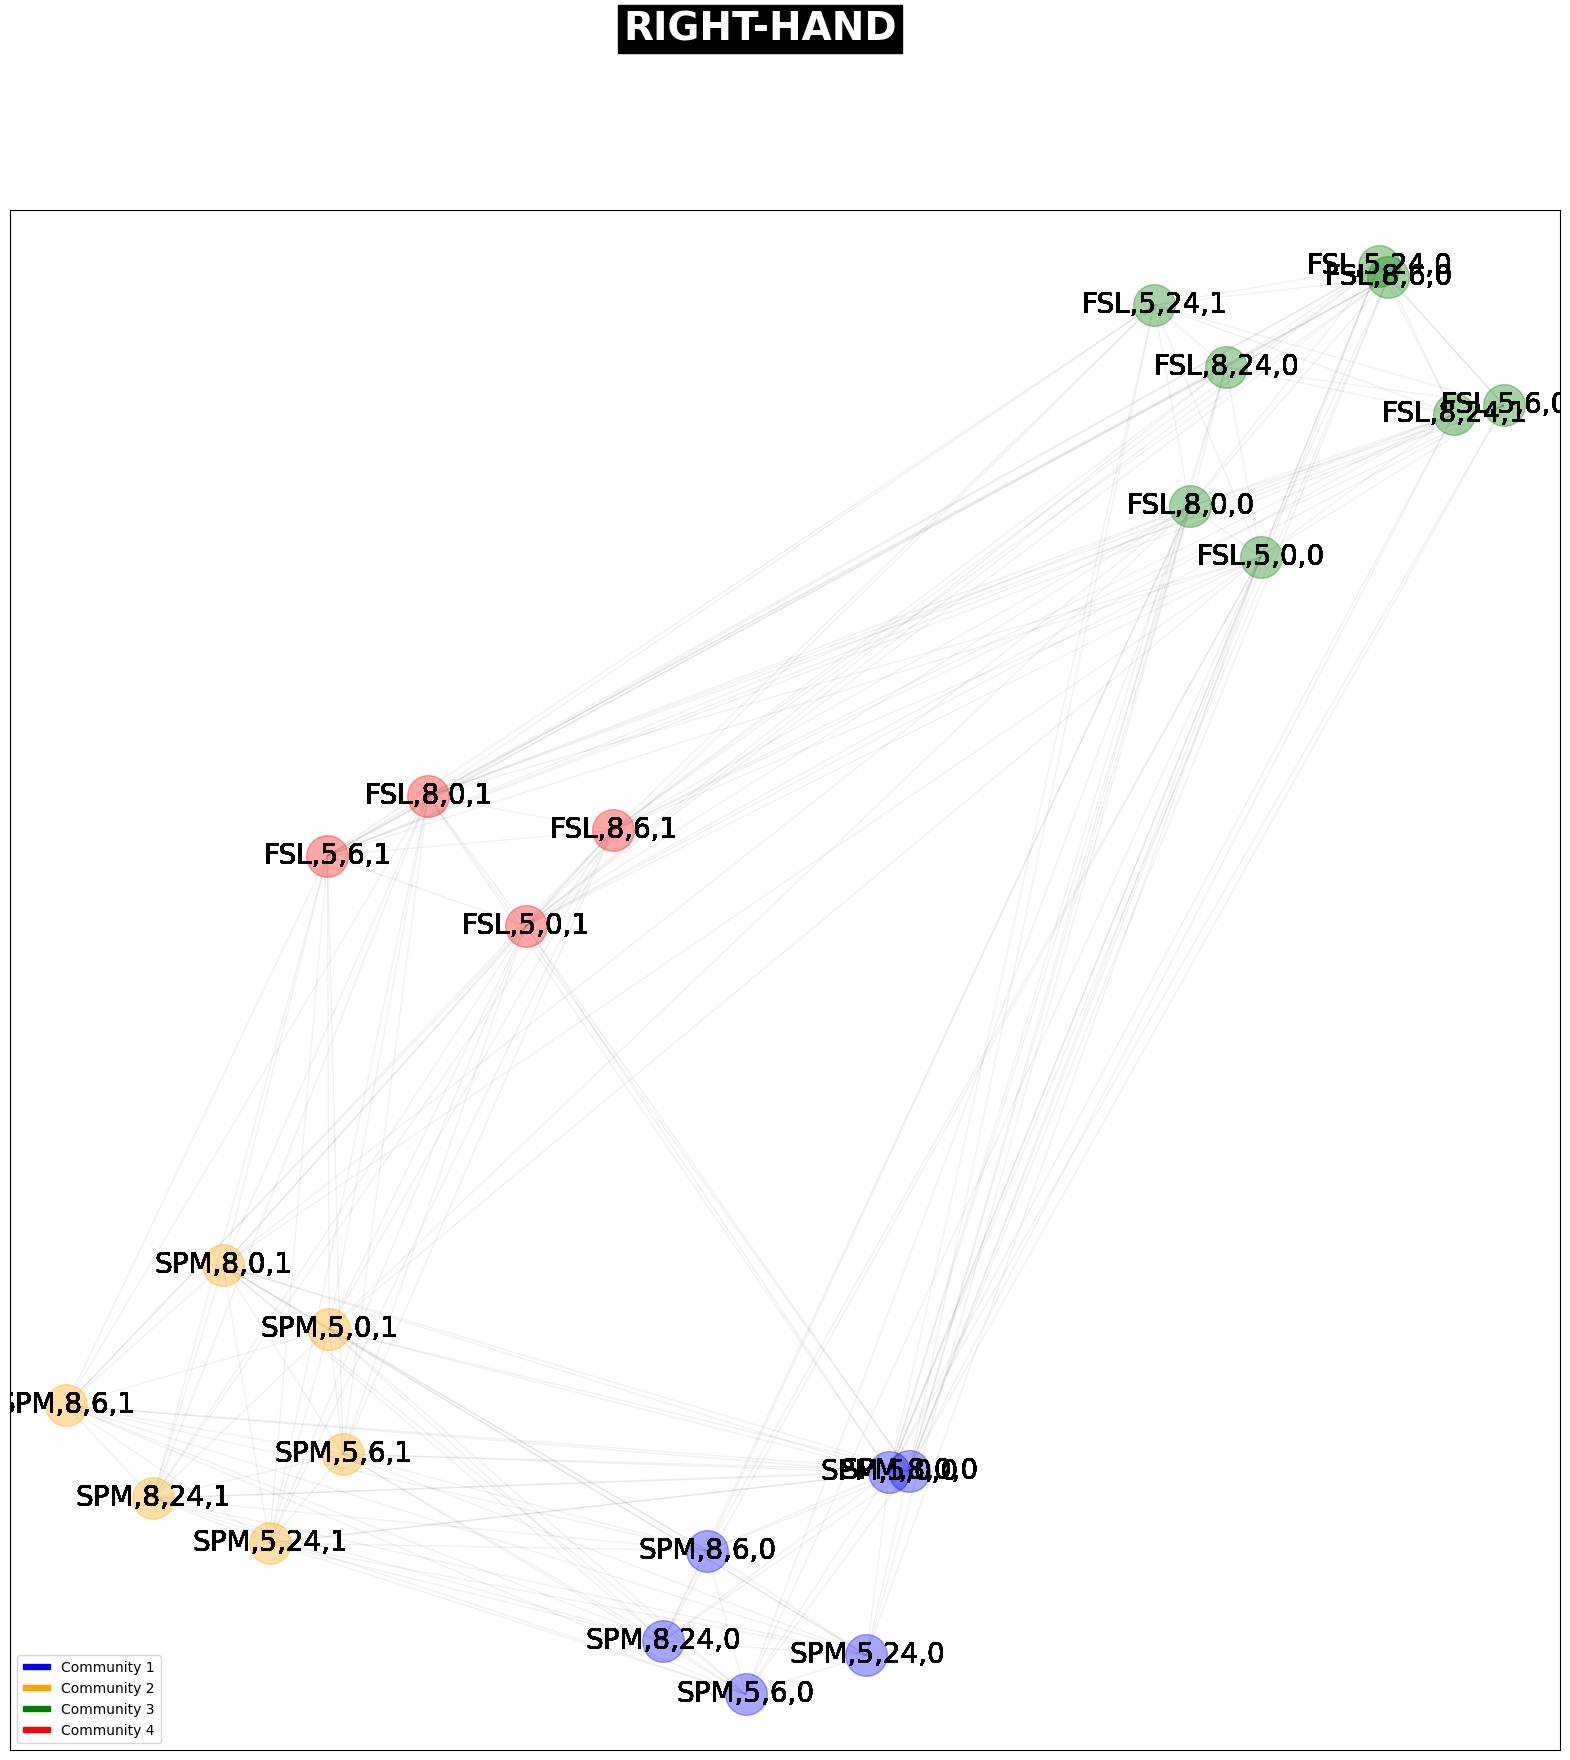

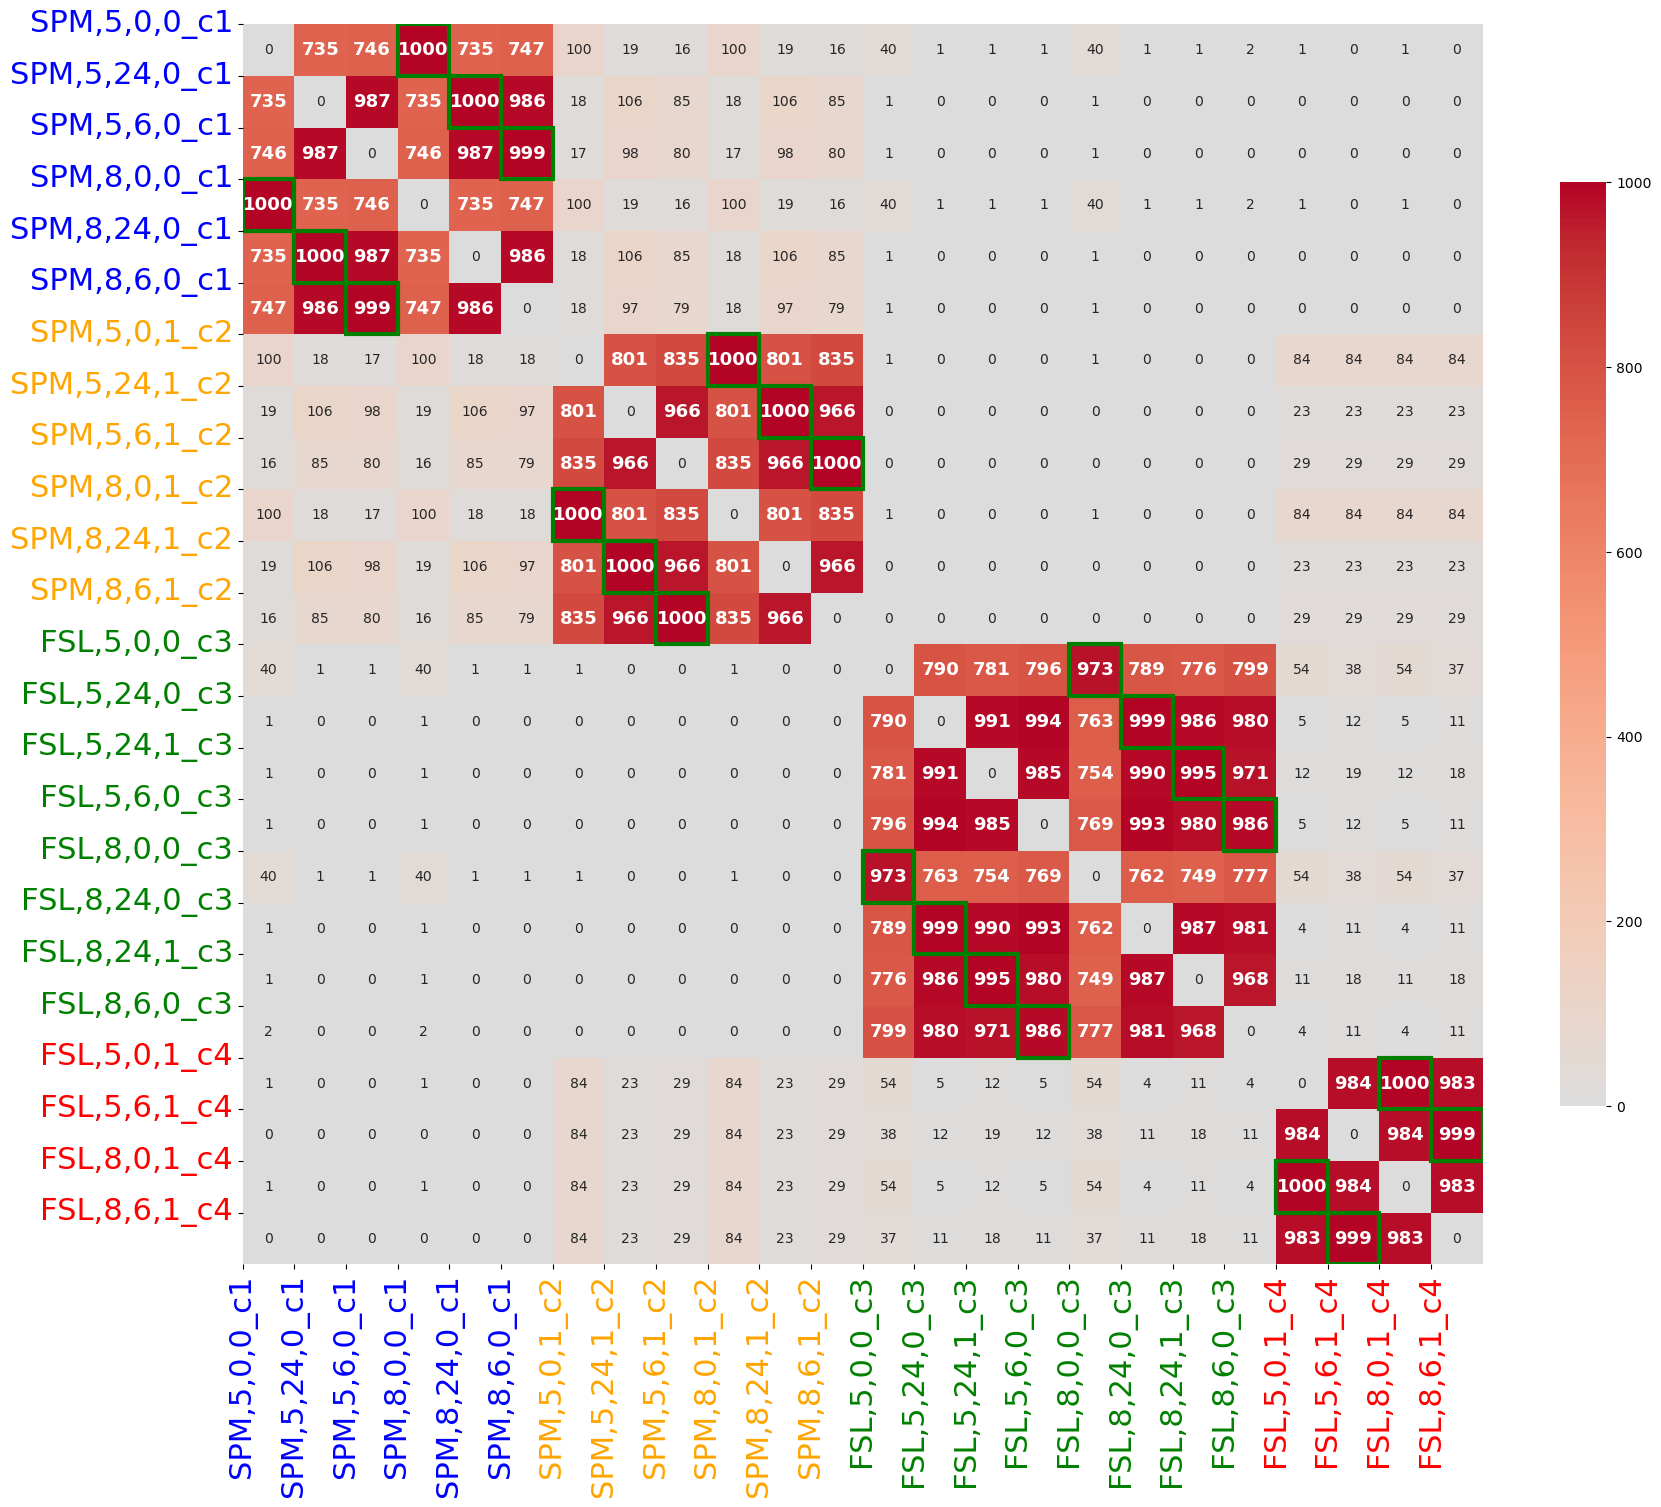

In [4]:
saving_names = [f'{repo_path}/figures/graph_{len(Qs)}_{data_type}s_{contrast}.png',
f'{repo_path}/figures/heatmap_{len(Qs)}_{data_type}s_{contrast}.png']

# Plot results 
louvain_utils.build_both_graph_heatmap(matrix_graph, G, partition, subject, saving_names, contrast, data_type)

## Quality control of graphs

In [6]:
communities = [[i for i in partition.keys() if partition[i]==p] for p in np.unique(list(partition.values())).tolist()]

community = {}
for k in range(len(communities)):
    community[k] = []
    for i, s in enumerate(subject):
        if i in communities[k]:
            community[k].append(s)  
print(community)

{0: ['SPM,5,0,0', 'SPM,5,24,0', 'SPM,5,6,0', 'SPM,8,0,0', 'SPM,8,24,0', 'SPM,8,6,0'], 1: ['SPM,5,0,1', 'SPM,5,24,1', 'SPM,5,6,1', 'SPM,8,0,1', 'SPM,8,24,1', 'SPM,8,6,1'], 2: ['FSL,5,0,0', 'FSL,5,24,0', 'FSL,5,24,1', 'FSL,5,6,0', 'FSL,8,0,0', 'FSL,8,24,0', 'FSL,8,24,1', 'FSL,8,6,0'], 3: ['FSL,5,0,1', 'FSL,5,6,1', 'FSL,8,0,1', 'FSL,8,6,1']}


In [7]:
A = nx.adjacency_matrix(G)
k_clusters=4
model = cluster.KMeans(n_clusters=k_clusters, n_init=200) 

model.fit(A.todense())

KMeans(n_clusters=4, n_init=200)

In [8]:
clusters = {}
for k in range(k_clusters):
    clusters[k] = []
    for i, s in enumerate(subject):
        if list(model.labels_)[i] == k:
            clusters[k].append(s)
print(clusters)

{0: ['SPM,5,0,0', 'SPM,5,24,0', 'SPM,5,6,0', 'SPM,8,0,0', 'SPM,8,24,0', 'SPM,8,6,0'], 1: ['FSL,5,0,0', 'FSL,5,24,0', 'FSL,5,24,1', 'FSL,5,6,0', 'FSL,8,0,0', 'FSL,8,24,0', 'FSL,8,24,1', 'FSL,8,6,0'], 2: ['SPM,5,0,1', 'SPM,5,24,1', 'SPM,5,6,1', 'SPM,8,0,1', 'SPM,8,24,1', 'SPM,8,6,1'], 3: ['FSL,5,0,1', 'FSL,5,6,1', 'FSL,8,0,1', 'FSL,8,6,1']}


In [9]:
print('Modularity of final graph:', nx.community.modularity(G, communities, weight='weight', resolution=1))
print('Coverage of final graph:', nx.community.partition_quality(G, communities)[0])
print('Performance of final graph:', nx.community.partition_quality(G, communities)[1])

Modularity of final graph: 0.6368737952757797
Coverage of final graph: 0.3404255319148936
Performance of final graph: 0.5507246376811594


## Mean maps visualisation

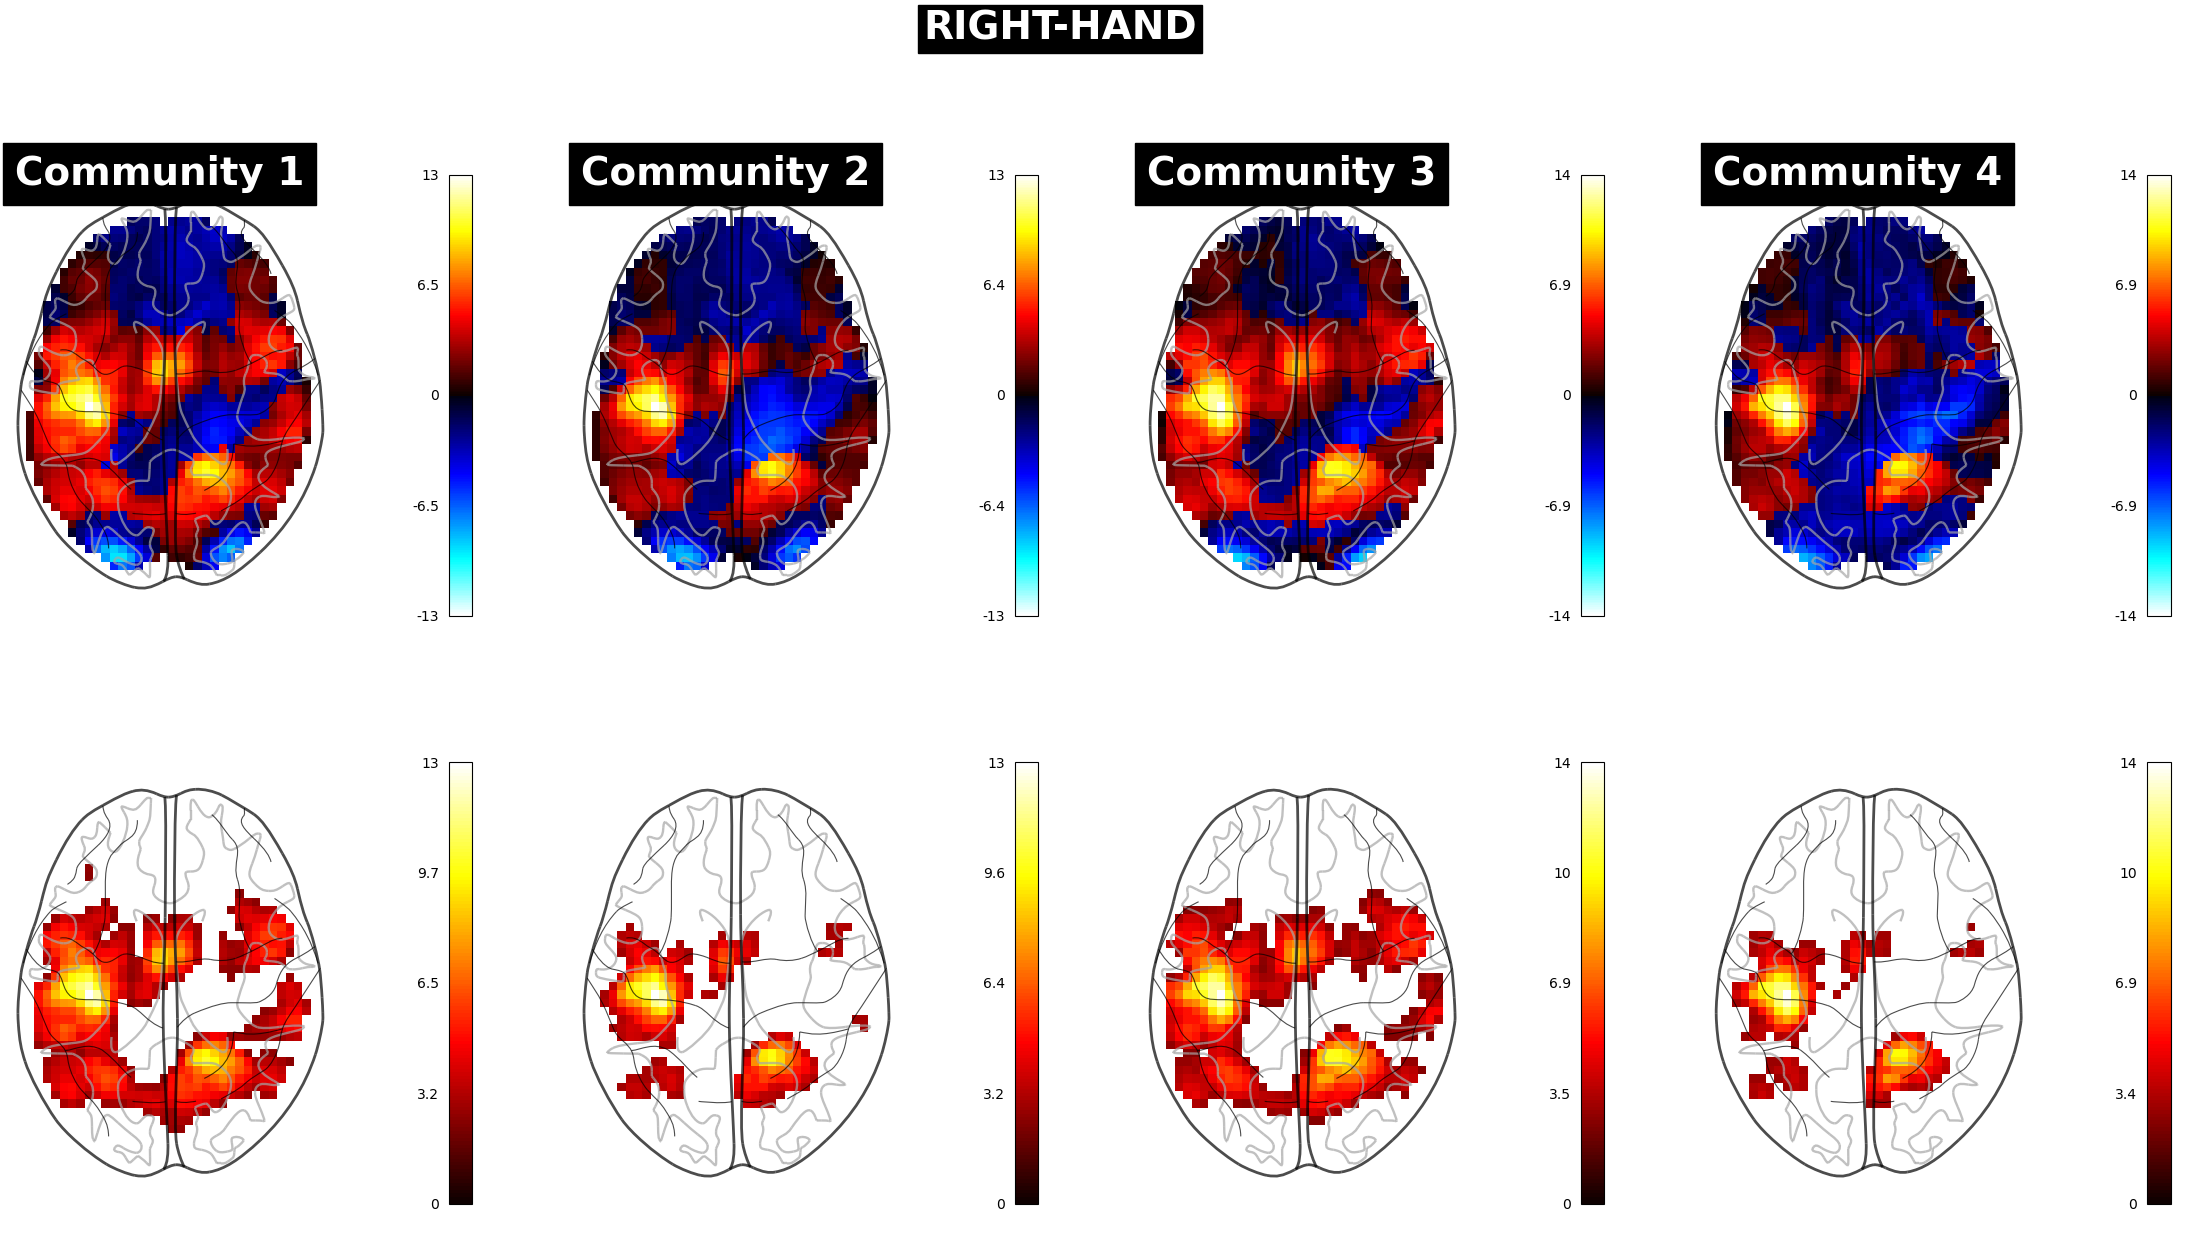

In [10]:
mean_maps_utils.plot_mean_image(contrast, partition, repo_path, data_type)

In [11]:
mean_maps_utils.get_activated_voxels(contrast, partition, repo_path, data_type)

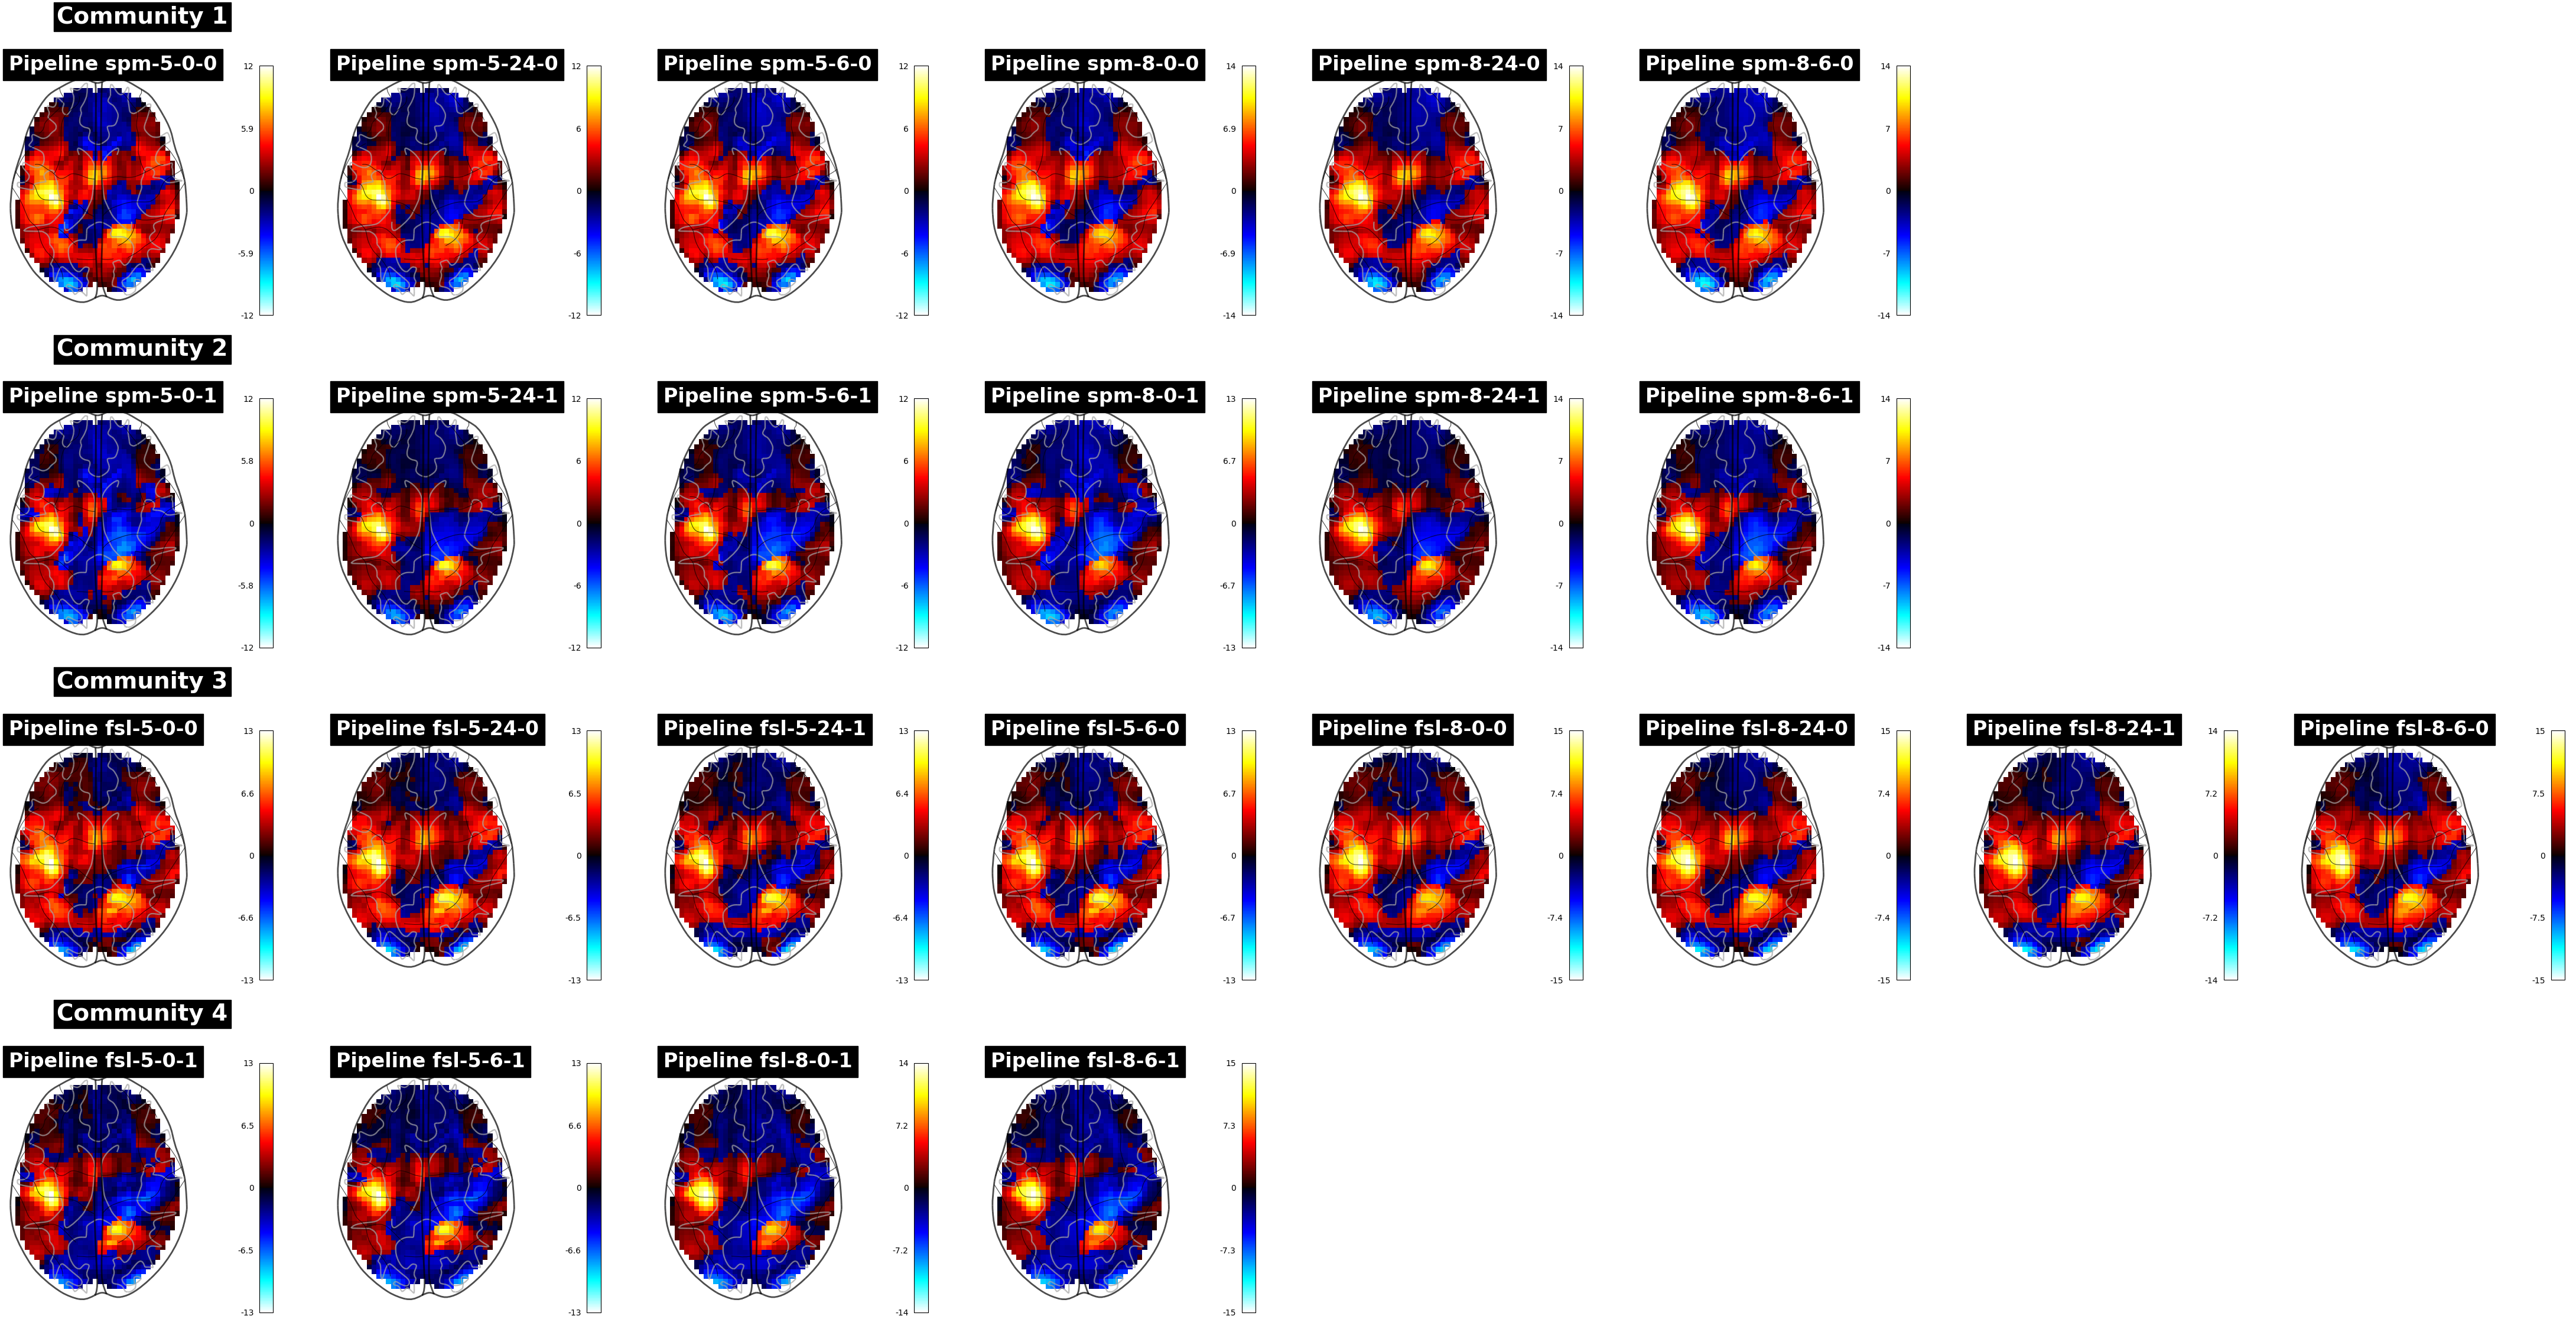

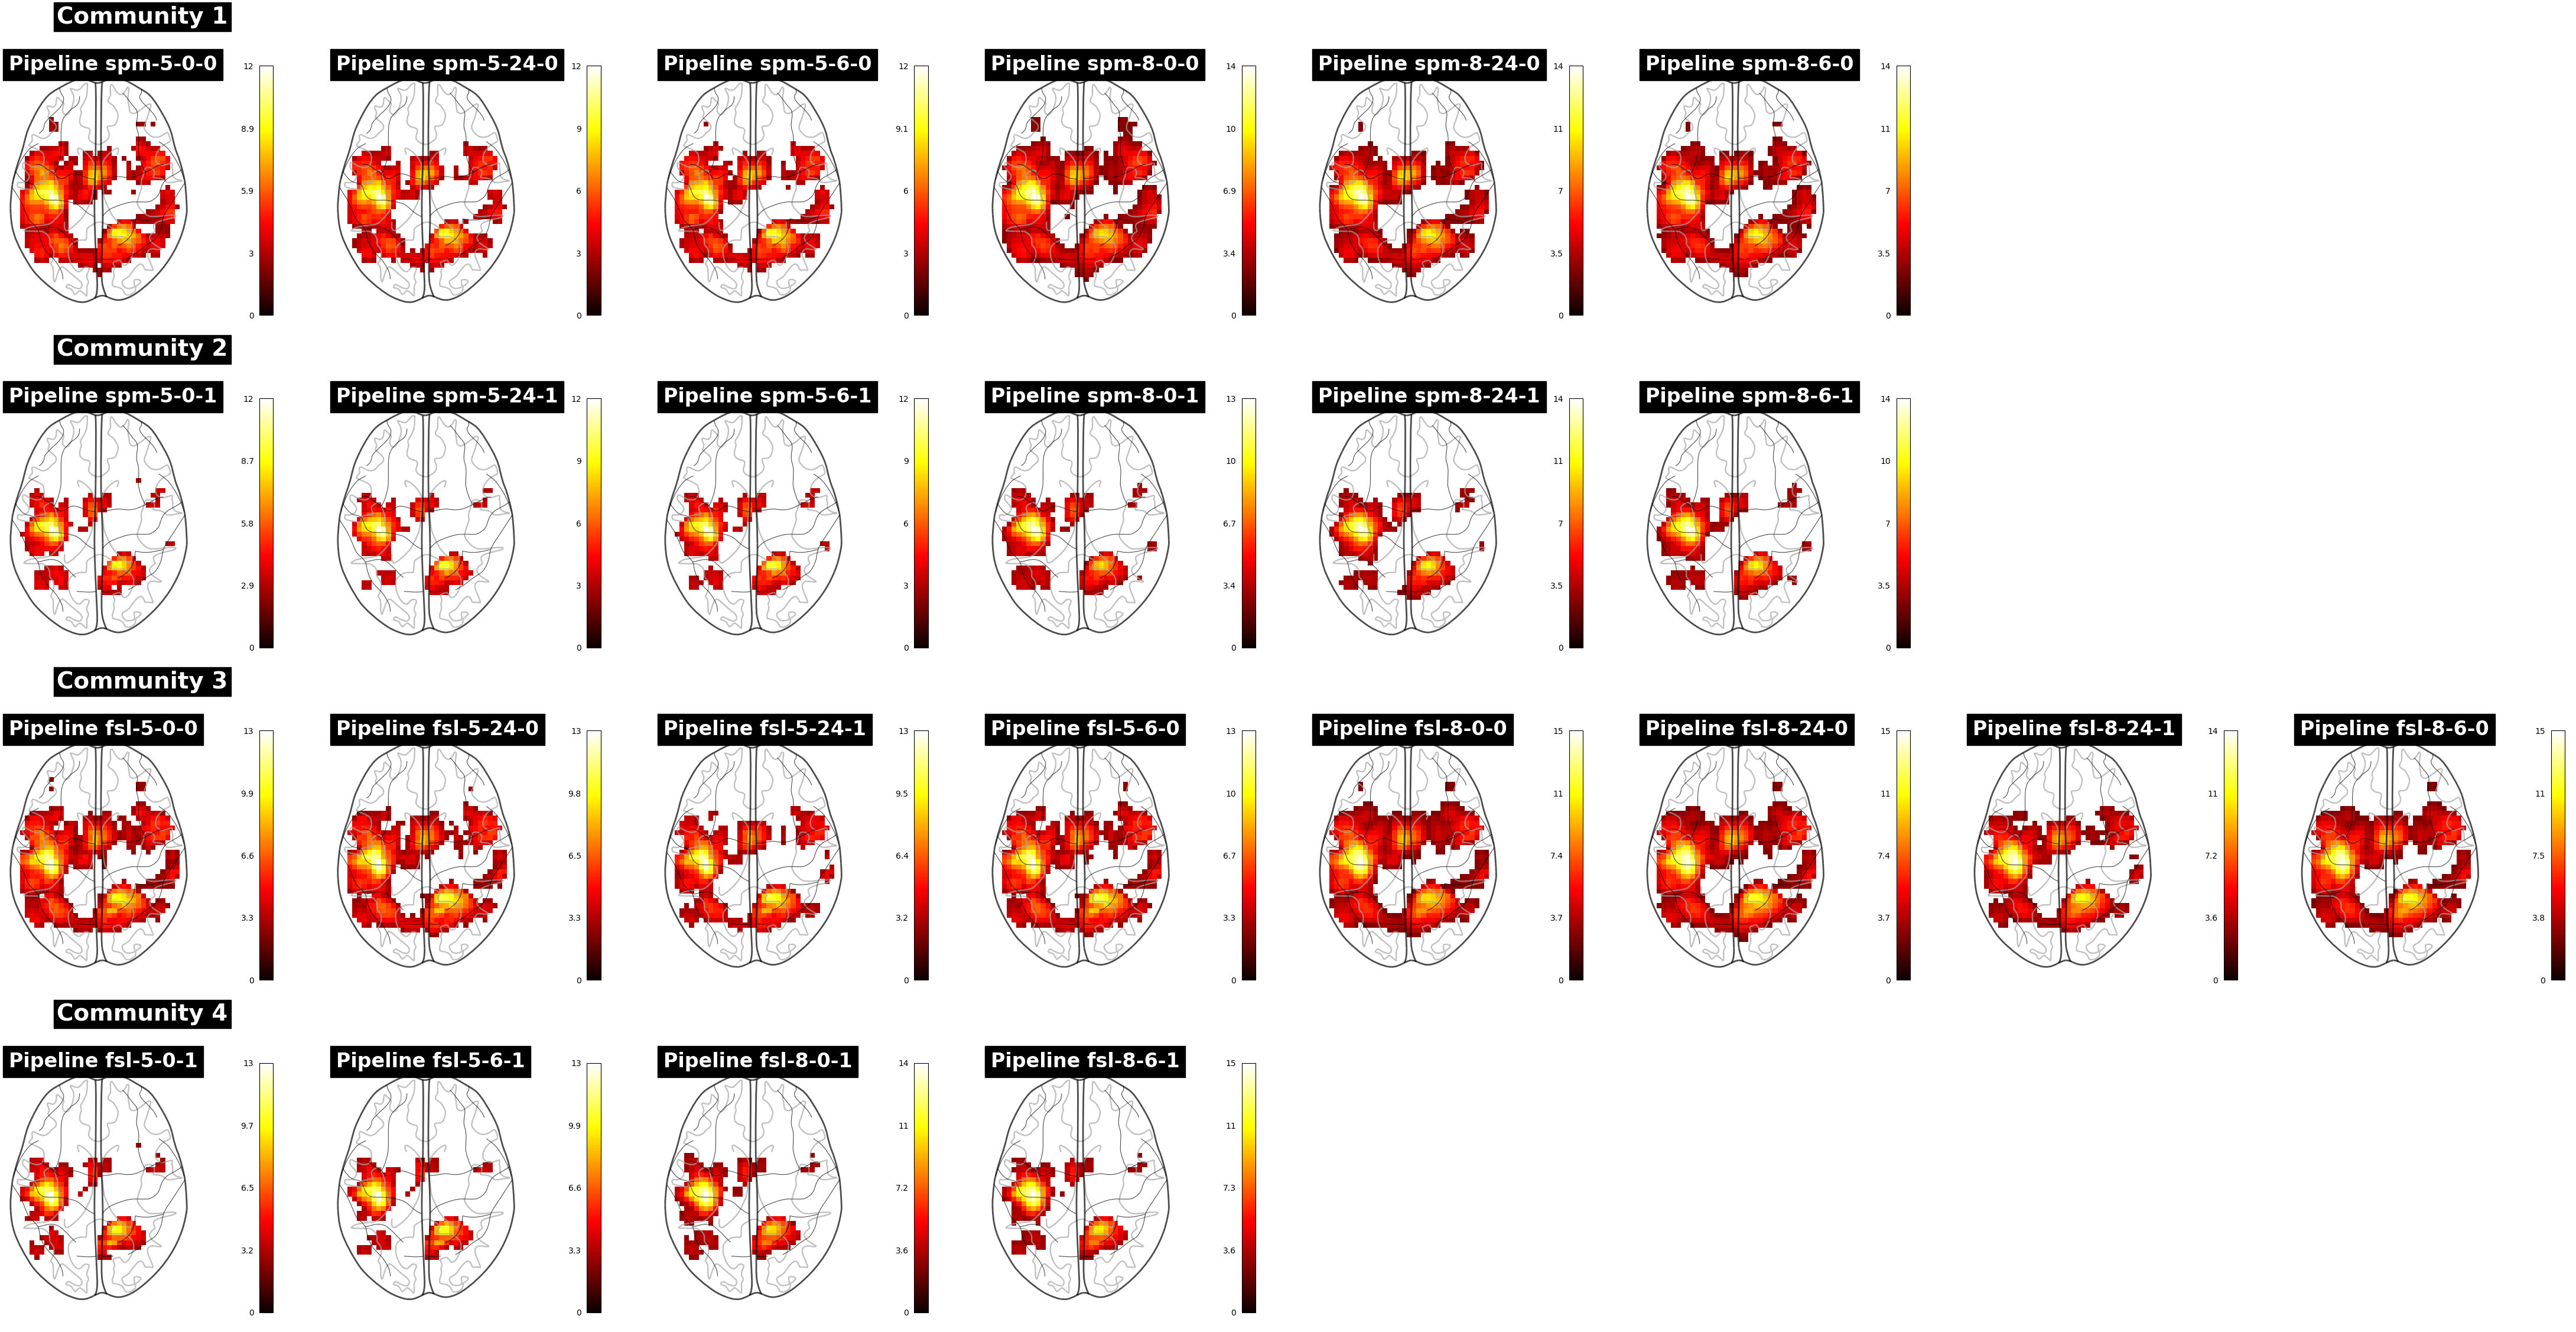

In [24]:
import importlib 
importlib.reload(mean_maps_utils)

mean_maps_utils.plot_pipeline_maps(contrast, partition, subject, repo_path, data_type)

In [21]:
mean_maps_utils.get_activated_voxels_pipelines(contrast, partition, subject, repo_path, data_type)